In [1]:
import torch
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd, create_mobilenetv1_ssd_predictor
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite, create_mobilenetv1_ssd_lite_predictor
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite, create_squeezenet_ssd_lite_predictor
from vision.datasets.voc_dataset import VOCDataset
from vision.datasets.open_images import OpenImagesDataset
from vision.utils import box_utils, measurements
from vision.utils.misc import str2bool, Timer
from vision.ssd.data_preprocessing import TrainAugmentation, TestTransform
from vision.ssd.config import vgg_ssd_config
from vision.ssd.ssd import MatchPrior

import argparse
import pathlib
import numpy as np
import logging
import sys

from road_datasets_3_3 import RoadDamageDataset


In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def group_annotation_by_class(dataset):
    true_case_stat = {}
    all_gt_boxes = {}
    all_difficult_cases = {}
    for i in range(len(dataset)):
        image_id, annotation = dataset.get_annotation(i)
        gt_boxes, classes, is_difficult = annotation
        gt_boxes = torch.from_numpy(gt_boxes)
        for i, difficult in enumerate(is_difficult):
            class_index = int(classes[i])
            gt_box = gt_boxes[i]
            if not difficult:
                true_case_stat[class_index] = true_case_stat.get(class_index, 0) + 1

            if class_index not in all_gt_boxes:
                all_gt_boxes[class_index] = {}
            if image_id not in all_gt_boxes[class_index]:
                all_gt_boxes[class_index][image_id] = []
            all_gt_boxes[class_index][image_id].append(gt_box)
            if class_index not in all_difficult_cases:
                all_difficult_cases[class_index]={}
            if image_id not in all_difficult_cases[class_index]:
                all_difficult_cases[class_index][image_id] = []
            all_difficult_cases[class_index][image_id].append(difficult)

    for class_index in all_gt_boxes:
        for image_id in all_gt_boxes[class_index]:
            all_gt_boxes[class_index][image_id] = torch.stack(all_gt_boxes[class_index][image_id])
    for class_index in all_difficult_cases:
        for image_id in all_difficult_cases[class_index]:
            all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])
    return true_case_stat, all_gt_boxes, all_difficult_cases


def compute_average_precision_per_class(num_true_cases, gt_boxes, difficult_cases,
                                        prediction_file, iou_threshold, use_2007_metric):
    with open(prediction_file) as f:
        image_ids = []
        boxes = []
        scores = []
        for line in f:
            t = line.rstrip().split(" ")
            image_ids.append(t[0])
            scores.append(float(t[1]))
            box = torch.tensor([float(v) for v in t[2:]]).unsqueeze(0)
            box -= 1.0  # convert to python format where indexes start from 0
            boxes.append(box)
        scores = np.array(scores)
        sorted_indexes = np.argsort(-scores)
        boxes = [boxes[i] for i in sorted_indexes]
        image_ids = [image_ids[i] for i in sorted_indexes]
        true_positive = np.zeros(len(image_ids))
        false_positive = np.zeros(len(image_ids))
        matched = set()
        for i, image_id in enumerate(image_ids):
            box = boxes[i]
            if image_id not in gt_boxes:
                false_positive[i] = 1
                continue

            gt_box = gt_boxes[image_id]
            ious = box_utils.iou_of(box, gt_box)
            max_iou = torch.max(ious).item()
            max_arg = torch.argmax(ious).item()
            if max_iou > iou_threshold:
                if difficult_cases[image_id][max_arg] == 0:
                    if (image_id, max_arg) not in matched:
                        true_positive[i] = 1
                        matched.add((image_id, max_arg))
                    else:
                        false_positive[i] = 1
            else:
                false_positive[i] = 1

    true_positive = true_positive.cumsum()
    false_positive = false_positive.cumsum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / num_true_cases
    if use_2007_metric:
        return measurements.compute_voc2007_average_precision(precision, recall),recall,precision
    else:
        return measurements.compute_average_precision(precision, recall)

In [3]:
eval_path = pathlib.Path('eval_results')
eval_path.mkdir(exist_ok=True)
timer = Timer()
label_file = "/data/RoadDamage/labels.txt"
class_names = [name.strip() for name in open(label_file).readlines()]

create_net = create_vgg_ssd
config = vgg_ssd_config


In [4]:
test_transform = TestTransform(config.image_size, config.image_mean, config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance,
                                  config.size_variance, 0.5)
dataset = RoadDamageDataset('/home/chiu/data/RoadDamage/data/', is_test=True)


true_case_stat, all_gb_boxes, all_difficult_cases = group_annotation_by_class(dataset)
net = create_net(len(class_names), is_test=True)

timer.start("Load Model")
net.load('/data/pytorch-ssd/checkpoint/3-3/VGG-Epoch-410.pth')

net = net.to(DEVICE)

print(f'It took {timer.end("Load Model")} seconds to load the model.')
      
predictor = create_vgg_ssd_predictor(net, nms_method="hard", device=DEVICE)
      

/data/anaconda/envs/neural/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


It took 0.8384780883789062 seconds to load the model.


In [5]:
results = []
for i in range(len(dataset)):
    print("process image", i)
    timer.start("Load Image")
    image = dataset.get_image(i)
    print("Load Image: {:4f} seconds.".format(timer.end("Load Image")))
    timer.start("Predict")
    boxes, labels, probs = predictor.predict(image,prob_threshold=0.08)
    print("Prediction: {:4f} seconds.".format(timer.end("Predict")))
    indexes = torch.ones(labels.size(0), 1, dtype=torch.float32) * i
    results.append(torch.cat([
            indexes.reshape(-1, 1),
            labels.reshape(-1, 1).float(),
            probs.reshape(-1, 1),
            boxes + 1.0  # matlab's indexes start from 1
    ], dim=1))
results = torch.cat(results)


process image 0
Load Image: 0.017305 seconds.
Inference time:  0.024295568466186523
Prediction: 0.029783 seconds.
process image 1
Load Image: 0.016172 seconds.
Inference time:  0.01940131187438965
Prediction: 0.023448 seconds.
process image 2
Load Image: 0.013781 seconds.
Inference time:  0.020625829696655273
Prediction: 0.023913 seconds.
process image 3
Load Image: 0.009951 seconds.
Inference time:  0.019028902053833008
Prediction: 0.022829 seconds.
process image 4
Load Image: 0.011189 seconds.
Inference time:  0.019108295440673828
Prediction: 0.022985 seconds.
process image 5
Load Image: 0.010165 seconds.
Inference time:  0.024466753005981445
Prediction: 0.035131 seconds.
process image 6
Load Image: 0.010575 seconds.
Inference time:  0.019409656524658203
Prediction: 0.027095 seconds.
process image 7
Load Image: 0.014049 seconds.
Inference time:  0.020216941833496094
Prediction: 0.025909 seconds.
process image 8
Load Image: 0.017709 seconds.
Inference time:  0.01934361457824707
Predic

In [6]:
for class_index, class_name in enumerate(class_names):
    if class_index == 0: continue  # ignore background
    prediction_path = eval_path / f"det_test_{class_name}.txt"
    with open(prediction_path, "w") as f:
        sub = results[results[:, 1] == class_index, :]
        for i in range(sub.size(0)):
            prob_box = sub[i, 2:].numpy()
            image_id = dataset.ids[int(sub[i, 0])]
            print(
                image_id + " " + " ".join([str(v) for v in prob_box]),
                file=f
            )
aps = []
print("\n\nAverage Precision Per-class:")
for class_index, class_name in enumerate(class_names):
    if class_index == 0:
        continue
    prediction_path = eval_path / f"det_test_{class_name}.txt"
    ap,recall,precision = compute_average_precision_per_class(
        true_case_stat[class_index],
        all_gb_boxes[class_index],
        all_difficult_cases[class_index],
        prediction_path,
        0.5,
        True
    )
    aps.append(ap)
    average_recall = np.sum(recall)/len(recall)
    average_precision = np.sum(precision)/len(precision)

    print(f"{class_name}: {ap}, recall:{average_recall}, precision:{average_precision}")

print(f"\nAverage Precision Across All Classes:{sum(aps)/len(aps)}")



Average Precision Per-class:
D00: 0.4739466164591134, recall:0.7675955664714403, precision:0.14545625809921647
D01: 0.666475166972474, recall:0.8032282357052375, precision:0.3117878731258269
D10: 0.06873656767151941, recall:0.24337360362205085, precision:0.073575496011377
D11: 0.004329004329004329, recall:0.039786625032526675, precision:0.009636124430337106
D20: 0.6666298429746613, recall:0.7095937725000783, precision:0.46190577606013866
D40: 0.11598746081504702, recall:0.15709189899558812, precision:0.06714362859976432
D43: 0.8120294800744137, recall:0.8617776111833837, precision:0.31273468842984975
D44: 0.6691165914662419, recall:0.7982436507872875, precision:0.26848577969753046

Average Precision Across All Classes:0.4346563413453094


Inference time:  0.03701043128967285


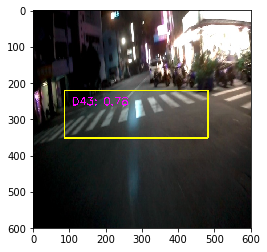

In [37]:
import cv2
from matplotlib import pyplot as plt

image_path = '/data/RoadDamage/data/all/JPEGImages/2019_0510_234009_059_001400.jpg'




orig_image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)

image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)

sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0)

sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1)

sobelX = np.uint8(np.absolute(sobelX))

sobelY = np.uint8(np.absolute(sobelY))

sobelCombined = cv2.bitwise_or(sobelX, sobelY)

image = np.stack((sobelCombined,)*3, axis=-1)

boxes, labels, probs = predictor.predict(image, 10, 0.4)

for i in range(boxes.size(0)):
    box = boxes[i, :]
    cv2.rectangle(orig_image, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 4)
    #label = f"""{voc_dataset.class_names[labels[i]]}: {probs[i]:.2f}"""
    label = f"{class_names[labels[i]]}: {probs[i]:.2f}"
    cv2.putText(orig_image, label,
                (box[0] + 20, box[1] + 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,  # font scale
                (255, 0, 255),
                2)  # line type
plt.imshow(orig_image)
plt.show()